# Neural network for the MNIST dataset

### Importing and inspecting the data

In [19]:
# Loading the data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

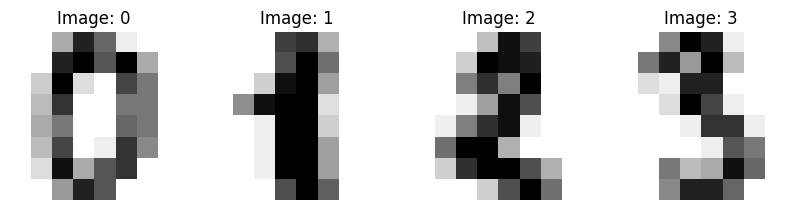

In [20]:
# Importing from sklearn
digits = datasets.load_digits()

# Inspecting four first images
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Image: %i" % label)

### Explore the data

Just checking if the data is relatively evenly distrubuted, because this will effect the performance

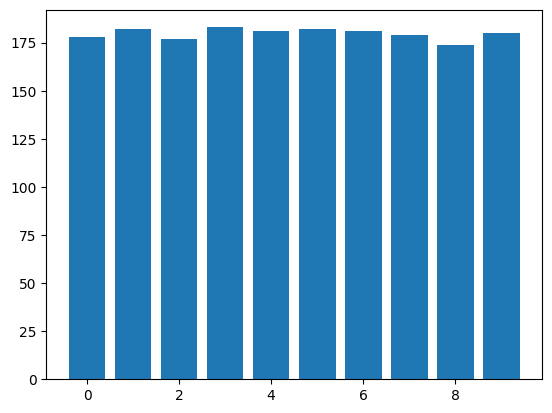

In [29]:
# Plotting the accurances of different values
label_counts = np.bincount(digits.target)

plt.bar(range(len(label_counts)), label_counts)
plt.show()

### Split into training and test sets

In [21]:
# Get the data and targets
X = digits.data
y = digits.target

# Shuffle the data 
np.random.seed(42)
indices = np.random.permutation(len(X))

# Define the split ratio for the training and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# Split the indices into training and testing
X_train, y_train = X[indices[:split_index]], y[indices[:split_index]]
X_test, y_test = X[indices[split_index:]], y[indices[split_index:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1437, 64), (1437,), (360, 64), (360,))

## Building the forward pass for the model

First we need to make the forward pass for the neural network. The forward pass consists of:

**Weighted sum**

$$
Z^{(l)} = A^{(l-1)} W^{(l)} + b^{(l)}
$$

This gives a linear transformation of the input data by combining inputs and weights. The activation function is then applied to introduce non-linearity

**Activation functions**

* **ReLU activation function**
$$
f(z) = \text{ReLU}(z) = \max(0, z)
$$

* **Softmax**
    Softmax converts raw prediction scores (logits) into probabilities. It is used in the output layer of multi-class classification problems like MNIST. It ensures    that the sum of probabilities across all classes is 1.
$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

In [30]:
def relu(x):
    return max(0,x)

def relu_derivative(x): 
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

## Building the backpropegation

The **backpropagation** process in a neural network is used to update the weights and biases based on the error (loss) computed during the forward pass. It works by calculating the gradients of the loss function with respect to the weights and propagating the error backward through the network using the chain rule of differentiation.

##### Step 1: Categorical Cross-Entropy Loss

For the backpropagation process, we first need to compute the error using a loss function. In the case of classification tasks, we typically use **categorical cross-entropy loss**:

$$
\mathcal{L}(\hat{y}, y) = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Where:
- \( y_i \) is the true label (one-hot encoded vector),
- \( \hat{y}_i \) is the predicted probability for class \( i \),
- \( C \) is the number of classes.

This loss measures how far the predicted probability distribution \( \hat{y} \) is from the true label \( y \).


##### Step 2: Gradient of the Loss with Respect to Output

Once the loss is computed, we calculate the gradient of the loss with respect to the output of the network (i.e., the softmax probabilities \( \hat{y} \)). The gradient for **categorical cross-entropy** is:

$$
\frac{\partial \mathcal{L}}{\partial \hat{y}_i} = \hat{y}_i - y_i
$$

This gradient tells us how much the predicted probability \( \hat{y}_i \) deviates from the true label \( y_i \).


##### Step 3: Backpropagation to Output Layer

For the **output layer**, the backpropagation process begins by computing the gradient of the loss with respect to the weighted sum \( Z^{(L)} \) at the output layer. Using the chain rule:

$$
\frac{\partial \mathcal{L}}{\partial Z^{(L)}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial Z^{(L)}}
$$

Since \( \frac{\partial \hat{y}}{\partial Z^{(L)}} \) is simplified by the properties of softmax, this results in:

$$
\frac{\partial \mathcal{L}}{\partial Z^{(L)}} = \hat{y} - y
$$

This is the error signal we propagate back through the network.


##### Step 4: Backpropagation to Hidden Layers

For each hidden layer \( l \), we propagate the error backward using the chain rule. The gradient of the loss with respect to the weights and biases in layer \( l \) is calculated as follows:

**Gradient of Weights:**
$$
\frac{\partial \mathcal{L}}{\partial W^{(l)}} = A^{(l-1)T} \cdot \delta^{(l)}
$$

Where:
- \( A^{(l-1)} \) is the activation from the previous layer (or input data for the first layer),
- \( \delta^{(l)} \) is the error signal propagated from the next layer.

**Gradient of Biases:**
$$
\frac{\partial \mathcal{L}}{\partial b^{(l)}} = \sum \delta^{(l)}
$$

Where:
- \( \sum \delta^{(l)} \) is the sum of the error signal over all the samples in the batch.

**Gradient of Input:**
$$
\delta^{(l-1)} = \delta^{(l)} \cdot W^{(l)T}
$$

This step propagates the error backward to the previous layer so that its weights and biases can also be updated.


##### Step 5: Weight Update Rule

Finally, we update the weights and biases using **gradient descent**. The update rule for the weights is:

$$
W^{(l)} = W^{(l)} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial W^{(l)}}
$$

And for the biases:

$$
b^{(l)} = b^{(l)} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial b^{(l)}}
$$

Where:
- \( \alpha \) is the learning rate,
- \( \frac{\partial \mathcal{L}}{\partial W^{(l)}} \) and \( \frac{\partial \mathcal{L}}{\partial b^{(l)}} \) are the gradients of the loss with respect to the weights and biases, respectively.


In [ ]:
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

## Creating the Layers

In [32]:
class Layer:
    def __init__(self, input_size, output_size):
        # Initialize weights with small random values and biases to 0
        self._weights = np.random.randn(input_size, output_size) * 0.1
        self._bias = np.zeros((1, output_size))

    def forward(self, inputs):
        # Calculate the weighted sum of inputs + biases
        self._inputs = inputs
        self.output = np.dot(inputs, self._weights) + self._bias

    def backward(self, d_output, learning_rate):
        # Gradient of weights and biases based on the error signal (d_output)
        d_weights = np.dot(self._inputs.T, d_output)
        d_biases = np.sum(d_output, axis=0, keepdims=True)

        # Gradient of the input to pass to the previous layer
        d_inputs = np.dot(d_output, self._weights.T)

        # Update weights and biases
        self._weights -= learning_rate * d_weights
        self._biases -= learning_rate * d_biases

        return d_inputs

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize two layers: one hidden and one output
        self.layer1 = Layer(input_size, hidden_size)
        self.layer2 = Layer(hidden_size, output_size)

    def forward(self, X):
        # Forward pass through the first layer with ReLU activation
        self.layer1.forward(X)
        self.layer1_output = relu(self.layer1.output)

        # Forward pass through the second layer with Softmax activation
        self.layer2.forward(self.layer1_output)
        self.output = softmax(self.layer2.output)

    def backward(self, X, y, learning_rate):
        # Backward pass using Cross-Entropy Loss
        loss = cross_entropy_loss(y, self.output)
        d_output = self.output - y

        # Backward pass through second layer
        d_hidden = self.layer2.backward(d_output, learning_rate)

        # Backward pass through the first layer with ReLU activation
        d_inputs = self.layer1.backward(d_hidden * relu_derivative(self.layer1_output), learning_rate)

    def train(self, X_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            self.forward(X_train)
            self.backward(X_train, y_train, learning_rate)

            # Print the loss every 100 epochs
            if epoch % 100 == 0:
                loss = cross_entropy_loss(y_train, self.output)
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        # Forward pass for predictions
        self.forward(X)
        return np.argmax(self.output, axis=1)

### Test the model

In [33]:
# Hyperparameters
input_size = 784
hidden_size = 64
output_size = 10
epochs = 1000
learning_rate = 0.01

# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the neural network
nn.train(X_train, y_train, epochs, learning_rate)


ValueError: shapes (1437,64) and (784,64) not aligned: 64 (dim 1) != 784 (dim 0)